In [2]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week,forecast_by_week, train_test_split
from PythonFiles.PlottingFunctions import hyperparameter_boxplots, plot_model_results_by_hp, hp_color_plot, plot_coverage
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import generate_model_results_by_hp_dict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.dataset.pandas import PandasDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
import ray
from ray.air import session
from ray import tune
import itertools
from gluonts.mx.distribution import NegativeBinomialOutput
config = Configuration()

# Default 100 runs on validation data

In [3]:
df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/ValidationPeriod/default_DeepAR_results_06_06.csv", sep=',')
fnn_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/ValidationPeriod/default_FNN_results_06_06.csv", sep=',')

hp_search_space = {
    "num_cells": tune.grid_search([40]),
    "num_layers": tune.grid_search([2]),
    "context_length":tune.grid_search([4]),
    "cell_type":tune.grid_search(["lstm"]),
    "epochs":tune.grid_search([100]),
    "use_feat_static_real":tune.grid_search([False]),
    "use_feat_dynamic_real":tune.grid_search([False]),
    "use_feat_static_cat":tune.grid_search([False]),
    "cardinality":tune.sample_from(lambda spec:[2]*411 if spec.config.use_feat_static_cat else None),
}
fnn_hp_search_space = {
    #"num_hidden_dimensions": tune.grid_search([None]),
    #"context_length":tune.grid_search([None]),
    "epochs":tune.grid_search([100]),
    "prediction_length" : tune.grid_search([4]), 
    "num_batches_per_epoch":tune.grid_search([50]),
    "batch_normalization":tune.grid_search([False]),
    "batch_size":tune.grid_search([32]),
    }

# maybe also insert the default runs into the plots

model_results_by_hp, overall_df = generate_model_results_by_hp_dict(df, hp_search_space)
fnn_model_results_by_hp, fnn_overall_df = generate_model_results_by_hp_dict(fnn_df, fnn_hp_search_space)

                           total_modelruns  independent_combinations
modelruns_per_combination                                           
100.0                                  100                       1.0
                           total_modelruns  independent_combinations
modelruns_per_combination                                           
100.0                                  100                       1.0


# Tuned 100 runs on validation data

In [4]:
tuned_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/ValidationPeriod/Tuned_Deepar_Hyperparameter_results_06_06.csv", sep=',')
tuned_fnn_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/ValidationPeriod/Tuned_FNN_Hyperparameter_results_06_06.csv", sep=',')

tuned_hp_search_space = {
    "num_cells": tune.grid_search([140]),
    "num_layers": tune.grid_search([6]),
    "context_length":tune.grid_search([2]),
    "cell_type":tune.grid_search(["lstm"]),
    "epochs":tune.grid_search([200]),
    "use_feat_static_real":tune.grid_search([False]),
    "use_feat_dynamic_real":tune.grid_search([True]),
    "use_feat_static_cat":tune.grid_search([False]),
    "cardinality":tune.sample_from(lambda spec:[2]*411 if spec.config.use_feat_static_cat else None),
}

tuned_fnn_hp_search_space = {
    "num_hidden_dimensions": tune.grid_search([[40, 40, 40]]),
    "context_length":tune.grid_search([104]),
    "epochs":tune.grid_search([200]),
    "prediction_length" : tune.grid_search([4]), 
    "num_batches_per_epoch":tune.grid_search([60]),
    "batch_normalization":tune.grid_search([True]),
    "batch_size":tune.grid_search([124]),
    }

# maybe also insert the default runs into the plots

tuned_model_results_by_hp, tuned_overall_df = generate_model_results_by_hp_dict(tuned_df, tuned_hp_search_space)

tuned_fnn_model_results_by_hp, tuned_fnn_overall_df = generate_model_results_by_hp_dict(tuned_fnn_df, tuned_fnn_hp_search_space)

                           total_modelruns  independent_combinations
modelruns_per_combination                                           
100.0                                  100                       1.0
                           total_modelruns  independent_combinations
modelruns_per_combination                                           
100.0                                  100                       1.0


# Combine

In [5]:
overall_df_dict = {'default_DeepAR': overall_df,
                    'tuned_DeepAR':tuned_overall_df, 
                   'default_FNN':fnn_overall_df,
                   'tuned_FNN':tuned_fnn_overall_df,
}
model_results_by_hp_dict = {'default_DeepAR': model_results_by_hp,
                            'tuned_DeepAR':tuned_model_results_by_hp, 
                            'default_FNN':fnn_model_results_by_hp,
                            'tuned_FNN':tuned_fnn_model_results_by_hp}

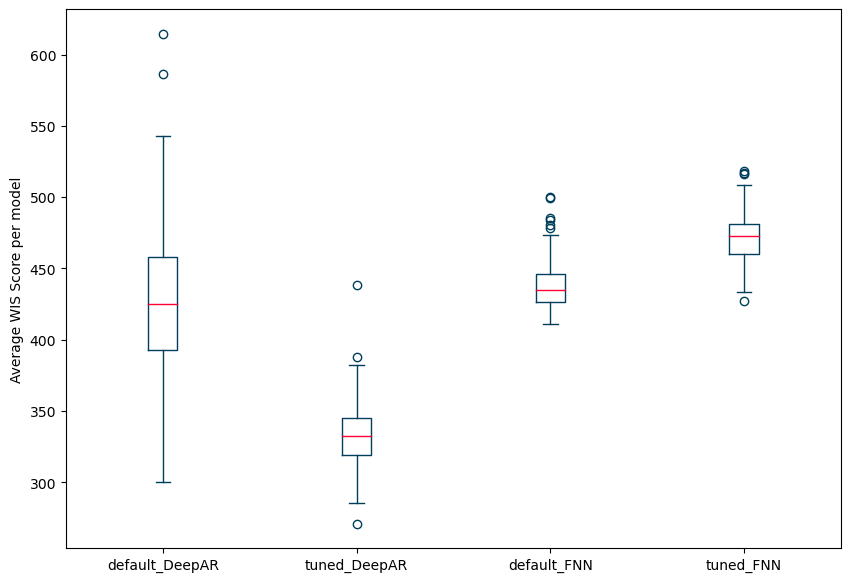

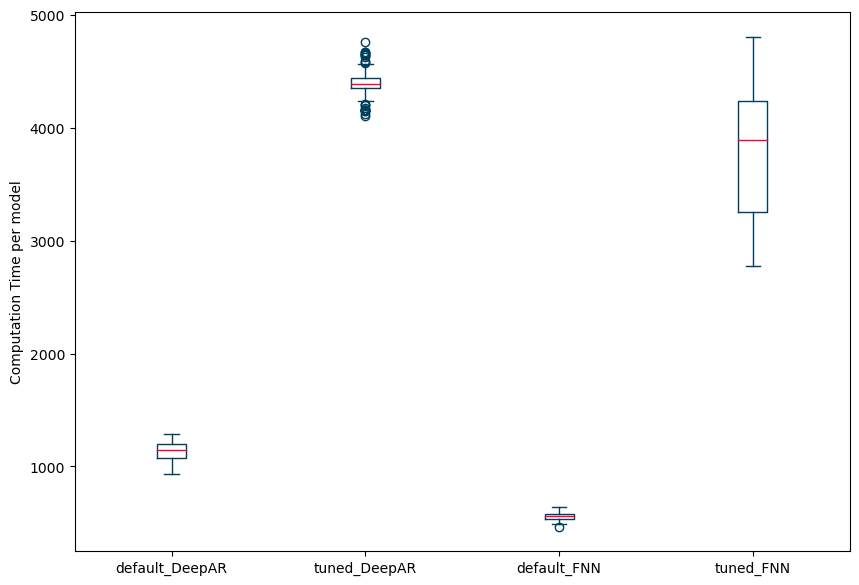

In [7]:
os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation')
#plot_model_results_by_hp(config, model_results_by_hp, hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=overall_df, sort_by="model_WIS_median", plottype="best", plot = "bp")
#plot_model_results_by_hp(config, fnn_model_results_by_hp, fnn_hp_search_space, number_of_plots=40, col="mean_WIS",figsize=(16, 9), overall_df=fnn_overall_df, sort_by="model_WIS_median", plottype="best", plot = "bp")
pos = range(1, 5, 1)
fig, ax = plt.subplots(figsize=(10, 7))
c = config.colors[0]
d = config.colors[1]
col ="mean_WIS"
i=0
for key in list(overall_df_dict.keys()):
    ax.boxplot(overall_df_dict[key][col], positions=[pos[i]],#notch=True, #patch_artist=True,
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=d))
    i += 1

# Set the x-axis ticks and tick labels
ax.set_xticks(pos)
ax.set_xticklabels(list(overall_df_dict.keys()))
# Set the y-axis label
ax.set_ylabel('Average WIS Score per model')
plt.savefig("MeanWISTunedComparison.png")
plt.show()

pos = range(1, 5, 1)
fig, ax = plt.subplots(figsize=(10, 7))
# Loop through each dataframe and plot a boxplot
c = config.colors[0]
d = config.colors[1]
col ="time_this_iter_s"
i=0
for key in list(overall_df_dict.keys()):
    ax.boxplot(overall_df_dict[key][col], positions=[pos[i]],#notch=True, #patch_artist=True,
                boxprops=dict(color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=d))
    i += 1

# Set the x-axis ticks and tick labels
ax.set_xticks(pos)
ax.set_xticklabels(list(overall_df_dict.keys()))

# Set the y-axis label
ax.set_ylabel('Computation Time per model') 

plt.savefig("TimeTunedComparison.png")
plt.show()
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')

In [63]:
added_cols = ["model_WIS_mean", "model_WIS_variance", "model_WIS_sd", "model_WIS_median", "model_time_mean", "model_time_variance", "model_time_sd",\
         "model_time_median"]#, "shape"]
print("DeepAR")
print(overall_df.sort_values("mean_WIS")[["mean_WIS", "time_this_iter_s"]+added_cols])
print("FNN")
print(fnn_overall_df.sort_values("mean_WIS")[["mean_WIS", "time_this_iter_s"]+added_cols])

DeepAR
      mean_WIS  time_this_iter_s  model_WIS_mean  model_WIS_variance  \
31  383.464842       5205.384689      452.875301          743.776302   
3   386.861479       4884.906243      452.875301          743.776302   
55  404.306839       4645.521712      452.875301          743.776302   
90  405.320968       4265.900280      452.875301          743.776302   
40  411.726186       5158.513104      452.875301          743.776302   
..         ...               ...             ...                 ...   
62  508.930679       4684.791791      452.875301          743.776302   
65  516.364990       4358.754721      452.875301          743.776302   
53  518.428584       4402.483618      452.875301          743.776302   
49  523.998788       5085.884364      452.875301          743.776302   
35  539.173271       4989.479974      452.875301          743.776302   

    model_WIS_sd  model_WIS_median  model_time_mean  model_time_variance  \
31     27.272263        451.164294       4842.35468 